# CNN(Convolutional Neural Network) 이미지 분류 모델

## 프로젝트 개요

이 노트북은 **CNN을 활용한 이미지 분류**의 전체 파이프라인을 다룹니다.  
실제 데이터셋 대신 **가상의 도형 이미지**를 직접 생성하여 사용합니다.

### 분류 대상 (5 클래스 - 자유롭게 추가/삭제 가능)
| 클래스 | 영문 | 설명 |
|--------|------|------|
| 원 | circle | 타원/원형 도형 |
| 사각형 | square | 직사각형 도형 |
| 삼각형 | triangle | 삼각형 도형 |
| 마름모 | diamond | 마름모 도형 |
| 십자 | cross | 십자(+) 도형 |

> **클래스를 늘리거나 줄이려면?**  
> `CLASS_NAMES`와 `CLASS_KR` 딕셔너리만 수정하면 됩니다.  
> 모델·학습·추론 코드는 `len(CLASS_NAMES)`를 기반으로 자동 확장됩니다.

### 전체 파이프라인
```
1. 가상 이미지 데이터 생성 (PIL로 도형 그리기)
2. PyTorch Dataset / DataLoader 구성
3. CNN 모델 아키텍처 정의 (입력 크기 자유, 클래스 수 자동)
4. 모델 학습 (Training & Validation)
5. 학습 결과 시각화
6. 새 이미지에 대한 추론 (Inference)
```

### CNN이란?
CNN(합성곱 신경망)은 이미지 인식에 특화된 딥러닝 모델입니다.  
핵심 구성 요소:
- **Conv2d (합성곱 층)**: 이미지에서 엣지, 텍스처, 패턴 등의 특징(feature)을 추출하는 필터
- **BatchNorm (배치 정규화)**: 학습 안정성을 높이고 수렴 속도를 개선
- **ReLU (활성화 함수)**: 비선형성을 부여하여 복잡한 패턴 학습 가능
- **MaxPool (최대 풀링)**: 특징 맵의 크기를 줄여 연산량 감소 + 위치 불변성 확보
- **AdaptiveAvgPool (적응적 평균 풀링)**: 어떤 입력 크기든 고정 크기로 변환
- **FC (완전 연결 층)**: 추출된 특징을 바탕으로 최종 클래스 분류

## 0. Import & 설정

In [1]:
import os
import random
import numpy as np
from PIL import Image, ImageDraw  # 가상 이미지 생성용

import torch
import torch.nn as nn             # 신경망 모듈 (Conv2d, Linear 등)
import torch.optim as optim       # 옵티마이저 (Adam)
from torch.utils.data import Dataset, DataLoader  # 데이터 로딩

# matplotlib 한글 폰트 설정 (macOS: AppleGothic)
import matplotlib
matplotlib.rcParams['font.family'] = 'AppleGothic'
matplotlib.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
import matplotlib.pyplot as plt

%matplotlib inline

# ── 재현성(Reproducibility) 보장 ──
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# ══════════════════════════════════════════════════════════
# ★ 클래스 설정 - 여기만 수정하면 전체 파이프라인이 자동 확장됩니다 ★
# ══════════════════════════════════════════════════════════
CLASS_NAMES = ["circle", "square", "triangle", "diamond", "cross"]
CLASS_KR = {
    "circle": "원",
    "square": "사각형",
    "triangle": "삼각형",
    "diamond": "마름모",
    "cross": "십자",
}
NUM_CLASSES = len(CLASS_NAMES)

IMG_SIZE = 64   # 기본 이미지 크기 (학습용, 추론 시에는 자유)
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "shape_data")

# ── 연산 장치 설정 ──
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device: {device}")
print(f"PyTorch: {torch.__version__}")
print(f"클래스 수: {NUM_CLASSES}개 → {list(CLASS_KR.values())}")
print(f"Data dir: {DATA_DIR}")

Device: cpu
PyTorch: 2.2.2
클래스 수: 5개 → ['원', '사각형', '삼각형', '마름모', '십자']
Data dir: /Users/roywoojinkim/Projects/pro1 /CNN/shape_data


## 1. 가상 이미지 데이터 생성

In [2]:
def generate_shape_image(shape: str, img_size: int = IMG_SIZE) -> Image.Image:
    """
    도형 하나를 랜덤 위치/크기/색상으로 그려 PIL 이미지 반환
    
    지원 도형: circle, square, triangle, diamond, cross
    (새 도형 추가 시 여기에 elif 블록만 추가하면 됩니다)
    
    Args:
        shape: 도형 종류 (CLASS_NAMES 중 하나)
        img_size: 이미지 한 변의 크기 (정사각형)
    Returns:
        PIL.Image: 생성된 RGB 이미지
    """
    # 1) 어두운 배경 생성
    bg = tuple(random.randint(0, 80) for _ in range(3))
    img = Image.new("RGB", (img_size, img_size), bg)
    draw = ImageDraw.Draw(img)

    # 2) 밝은 도형 색상 (배경과 대비)
    color = tuple(random.randint(150, 255) for _ in range(3))

    # 3) 랜덤 위치와 크기 계산
    margin = img_size // 6                                  # 여백
    size = random.randint(img_size // 3, img_size // 2)     # 도형 크기
    x0 = random.randint(margin, img_size - size - margin)   # 좌상단 x
    y0 = random.randint(margin, img_size - size - margin)   # 좌상단 y
    x1, y1 = x0 + size, y0 + size                          # 우하단

    # 4) 도형 그리기
    if shape == "circle":
        draw.ellipse([x0, y0, x1, y1], fill=color)
    elif shape == "square":
        draw.rectangle([x0, y0, x1, y1], fill=color)
    elif shape == "triangle":
        cx = (x0 + x1) // 2
        draw.polygon([(cx, y0), (x0, y1), (x1, y1)], fill=color)
    elif shape == "diamond":
        cx, cy = (x0 + x1) // 2, (y0 + y1) // 2
        draw.polygon([(cx, y0), (x1, cy), (cx, y1), (x0, cy)], fill=color)
    elif shape == "cross":
        w = size // 3  # 십자 팔 두께
        cx, cy = (x0 + x1) // 2, (y0 + y1) // 2
        draw.rectangle([cx - w // 2, y0, cx + w // 2, y1], fill=color)  # 세로
        draw.rectangle([x0, cy - w // 2, x1, cy + w // 2], fill=color)  # 가로

    return img


def create_dataset_on_disk(base_dir: str, n_per_class: int = 500):
    """
    디스크에 가상 이미지 데이터셋 생성
    CLASS_NAMES에 정의된 모든 클래스에 대해 자동 생성
    """
    for split, count in [("train", n_per_class), ("val", n_per_class // 5)]:
        for cls in CLASS_NAMES:
            folder = os.path.join(base_dir, split, cls)
            os.makedirs(folder, exist_ok=True)
            for i in range(count):
                img = generate_shape_image(cls)
                img.save(os.path.join(folder, f"{cls}_{i:04d}.png"))
    total_train = n_per_class * NUM_CLASSES
    total_val = (n_per_class // 5) * NUM_CLASSES
    print(f"데이터 생성 완료: train {n_per_class}장x{NUM_CLASSES} = {total_train}장, "
          f"val {n_per_class//5}장x{NUM_CLASSES} = {total_val}장")

In [3]:
create_dataset_on_disk(DATA_DIR, n_per_class=500)

데이터 생성 완료: train 500장x5 = 2500장, val 100장x5 = 500장


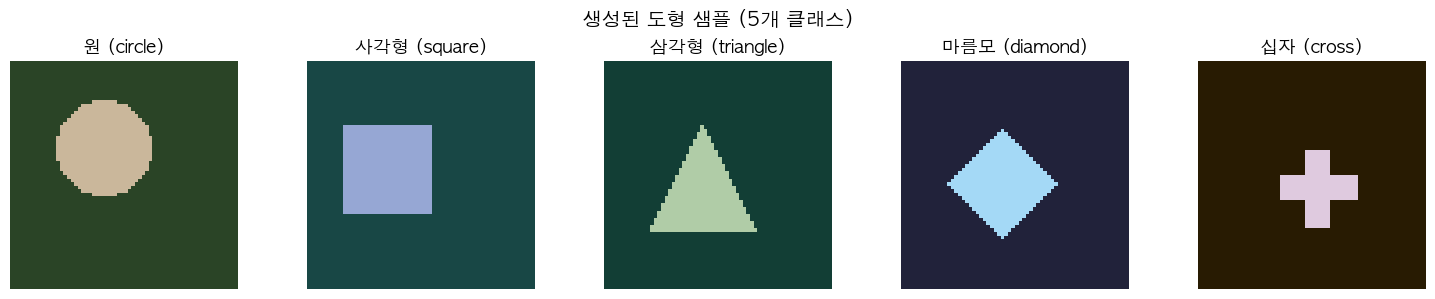

In [4]:
# 생성된 이미지 샘플 확인 (클래스 수에 맞게 자동 조절)
fig, axes = plt.subplots(1, NUM_CLASSES, figsize=(3 * NUM_CLASSES, 3))
for ax, cls in zip(axes, CLASS_NAMES):
    img = generate_shape_image(cls)
    ax.imshow(np.array(img))
    ax.set_title(f"{CLASS_KR[cls]} ({cls})", fontsize=13)
    ax.axis("off")
plt.suptitle(f"생성된 도형 샘플 ({NUM_CLASSES}개 클래스)", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

## 2. PyTorch Dataset / DataLoader

In [5]:
class ShapeDataset(Dataset):
    """폴더 구조에서 이미지를 읽어오는 Dataset"""

    def __init__(self, root_dir: str):
        self.samples = []
        for label, cls in enumerate(CLASS_NAMES):
            cls_dir = os.path.join(root_dir, cls)
            if not os.path.isdir(cls_dir):
                continue
            for fname in sorted(os.listdir(cls_dir)):
                if fname.endswith(".png"):
                    self.samples.append((os.path.join(cls_dir, fname), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        img = Image.open(path).convert("RGB")
        tensor = torch.from_numpy(np.array(img)).permute(2, 0, 1).float() / 255.0
        return tensor, label


# 데이터셋 & 로더 생성
train_ds = ShapeDataset(os.path.join(DATA_DIR, "train"))
val_ds = ShapeDataset(os.path.join(DATA_DIR, "val"))

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

print(f"Train: {len(train_ds)}장, Val: {len(val_ds)}장")

# 배치 확인
imgs, labels = next(iter(train_loader))
print(f"배치 shape: {imgs.shape}, labels: {labels[:8].tolist()}")

Train: 2500장, Val: 500장
배치 shape: torch.Size([32, 3, 64, 64]), labels: [2, 3, 4, 0, 1, 1, 0, 4]


---
## 3. CNN 모델 정의

3개의 Convolution 블록 + 2개의 Fully Connected 층으로 구성된 CNN입니다.

### 모델 아키텍처
```
입력: (3, H, W) ← 임의 크기의 RGB 이미지

  [Block 1] Conv2d(3→16) → BatchNorm → ReLU → MaxPool(2)
  [Block 2] Conv2d(16→32) → BatchNorm → ReLU → MaxPool(2)
  [Block 3] Conv2d(32→64) → BatchNorm → ReLU → MaxPool(2)

  [AdaptiveAvgPool2d(4, 4)]  ← 핵심! 어떤 크기든 (64, 4, 4)로 통일

  [Flatten] (64, 4, 4) → (1024,)
  [FC 1] Linear(1024→128) → ReLU → Dropout(0.3)
  [FC 2] Linear(128→3)   ← 3개 클래스 출력
```

### AdaptiveAvgPool2d란?
일반 MaxPool은 고정 커널 크기로 축소하지만, **AdaptiveAvgPool2d**는
**출력 크기를 지정**하면 입력 크기에 맞춰 자동으로 풀링합니다.

```
입력 (64, 8, 8)   → AdaptiveAvgPool2d(4) → 출력 (64, 4, 4) ✅
입력 (64, 16, 16)  → AdaptiveAvgPool2d(4) → 출력 (64, 4, 4) ✅
입력 (64, 32, 32)  → AdaptiveAvgPool2d(4) → 출력 (64, 4, 4) ✅
```
→ FC 층의 입력 크기가 항상 `64×4×4 = 1024`로 고정됩니다.

### 각 레이어의 역할
| 레이어 | 역할 |
|--------|------|
| **Conv2d** | 3×3 필터로 이미지를 스캔하며 특징(엣지, 곡선 등) 추출 |
| **BatchNorm2d** | 각 채널의 출력을 정규화 → 학습 안정화, 빠른 수렴 |
| **ReLU** | max(0, x) 활성화 → 비선형성 부여 |
| **MaxPool2d(2)** | 2×2 영역에서 최대값만 선택 → 크기 1/2, 위치 변화에 강건 |
| **AdaptiveAvgPool2d(4)** | 어떤 크기의 특징 맵이든 4×4로 통일 → 입력 크기 자유 |
| **Dropout(0.3)** | 학습 시 30% 뉴런 비활성화 → 과적합 방지 |

In [6]:
class SimpleCNN(nn.Module):
    """
    3-layer CNN for shape classification (입력 크기 자유, 클래스 수 자동)
    
    구조: [Conv → BN → ReLU → Pool] × 3 → AdaptiveAvgPool → FC
    입력: (batch, 3, H, W) ← 임의 크기 가능
    출력: (batch, num_classes) ← 클래스 수만큼 로짓 출력
    """

    def __init__(self, num_classes: int = 3):
        super().__init__()
        
        # ── 특징 추출부 (Feature Extractor) ──
        self.features = nn.Sequential(
            # Block 1: 입력 3채널(RGB) → 16개 특징 맵
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Block 2: 16 → 32개 특징 맵
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            # Block 3: 32 → 64개 특징 맵
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        
        # ── 적응적 풀링: 어떤 크기든 (64, 4, 4)로 통일 ──
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))
        
        # ── 분류부 (Classifier) ──
        self.classifier = nn.Sequential(
            nn.Flatten(),                        # (64, 4, 4) → (1024,)
            nn.Linear(64 * 4 * 4, 128),          # 1024 → 128
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),          # 128 → num_classes
        )

    def forward(self, x):
        """순전파: 이미지 → 특징 추출 → 적응적 풀링 → 분류"""
        x = self.features(x)
        x = self.adaptive_pool(x)
        x = self.classifier(x)
        return x


# 모델 생성 (NUM_CLASSES 자동 반영)
model = SimpleCNN(num_classes=NUM_CLASSES).to(device)
print(model)

total_params = sum(p.numel() for p in model.parameters())
print(f"\n총 파라미터: {total_params:,}개 | 출력 클래스: {NUM_CLASSES}개")

# 다양한 입력 크기 테스트
print("\n--- 입력 크기 호환성 테스트 ---")
for size in [32, 64, 128, 256]:
    dummy = torch.randn(1, 3, size, size).to(device)
    out = model(dummy)
    print(f"  입력 ({size}x{size}) → 출력 {out.shape} ✅")

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(4, 4))
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
   

  입력 (128x128) → 출력 torch.Size([1, 5]) ✅
  입력 (256x256) → 출력 torch.Size([1, 5]) ✅


## 4. 학습 (Training)

In [7]:
EPOCHS = 15
LR = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

history = {"train_loss": [], "val_loss": [], "val_acc": []}

for epoch in range(1, EPOCHS + 1):
    # --- Train ---
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    train_loss = running_loss / len(train_ds)

    # --- Validation ---
    model.eval()
    val_loss, correct = 0.0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            val_loss += criterion(outputs, labels).item() * imgs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()
    val_loss /= len(val_ds)
    val_acc = correct / len(val_ds) * 100

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch:2d}/{EPOCHS} | "
          f"train_loss={train_loss:.4f} | "
          f"val_loss={val_loss:.4f} | "
          f"val_acc={val_acc:.1f}%")

print(f"\n최종 Validation Accuracy: {history['val_acc'][-1]:.1f}%")

Epoch  1/15 | train_loss=0.5006 | val_loss=0.0649 | val_acc=99.6%


Epoch  2/15 | train_loss=0.0365 | val_loss=0.0086 | val_acc=100.0%


Epoch  3/15 | train_loss=0.0099 | val_loss=0.0051 | val_acc=100.0%


Epoch  4/15 | train_loss=0.0067 | val_loss=0.5129 | val_acc=87.2%


Epoch  5/15 | train_loss=0.0150 | val_loss=0.0012 | val_acc=100.0%


Epoch  6/15 | train_loss=0.0023 | val_loss=0.0016 | val_acc=100.0%


Epoch  7/15 | train_loss=0.0012 | val_loss=0.0005 | val_acc=100.0%


Epoch  8/15 | train_loss=0.0146 | val_loss=0.0160 | val_acc=99.6%


Epoch  9/15 | train_loss=0.0141 | val_loss=0.0406 | val_acc=98.6%


Epoch 10/15 | train_loss=0.0034 | val_loss=0.0002 | val_acc=100.0%


Epoch 11/15 | train_loss=0.0006 | val_loss=0.0001 | val_acc=100.0%


Epoch 12/15 | train_loss=0.0003 | val_loss=0.0001 | val_acc=100.0%


Epoch 13/15 | train_loss=0.0003 | val_loss=0.0001 | val_acc=100.0%


Epoch 14/15 | train_loss=0.0003 | val_loss=0.0001 | val_acc=100.0%


Epoch 15/15 | train_loss=0.0050 | val_loss=0.0009 | val_acc=100.0%

최종 Validation Accuracy: 100.0%


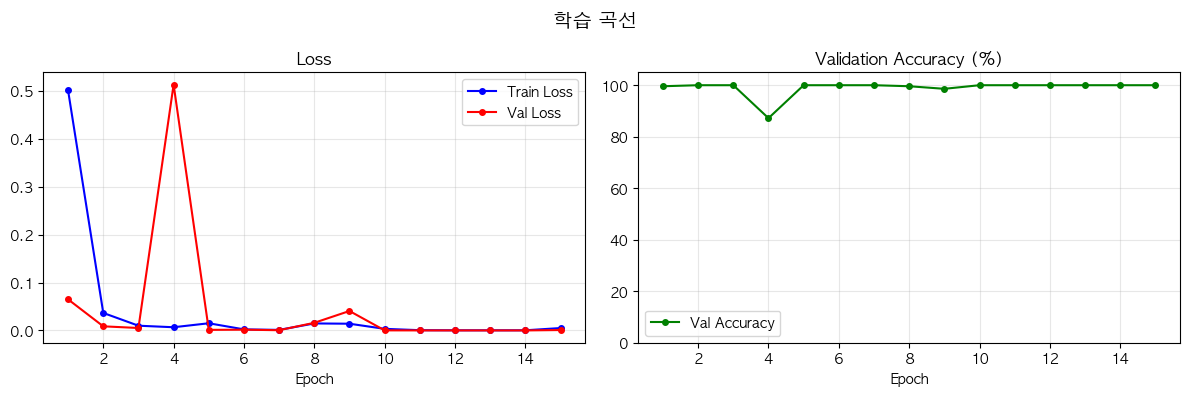

In [8]:
# 학습 곡선 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
epochs_range = range(1, EPOCHS + 1)

ax1.plot(epochs_range, history["train_loss"], "b-o", markersize=4, label="Train Loss")
ax1.plot(epochs_range, history["val_loss"], "r-o", markersize=4, label="Val Loss")
ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(epochs_range, history["val_acc"], "g-o", markersize=4, label="Val Accuracy")
ax2.set_title("Validation Accuracy (%)")
ax2.set_xlabel("Epoch")
ax2.set_ylim(0, 105)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle("학습 곡선", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

In [9]:
# 모델 저장
model_path = os.path.join(DATA_DIR, "cnn_shape_model.pth")
torch.save(model.state_dict(), model_path)
print(f"모델 저장 완료: {model_path}")

모델 저장 완료: /Users/roywoojinkim/Projects/pro1 /CNN/shape_data/cnn_shape_model.pth


## 5. 추론 (Inference)

In [10]:
# ── 모델 로드 (새로 불러오기 테스트) ──
# 실제 배포 시에는 학습 없이 이 부분만 실행하면 됩니다.
inference_model = SimpleCNN(num_classes=NUM_CLASSES).to(device)
inference_model.load_state_dict(
    torch.load(model_path, map_location=device, weights_only=True)
)
inference_model.eval()  # 반드시 eval 모드로 전환!
print(f"모델 로드 완료 (클래스 {NUM_CLASSES}개)")

모델 로드 완료 (클래스 5개)


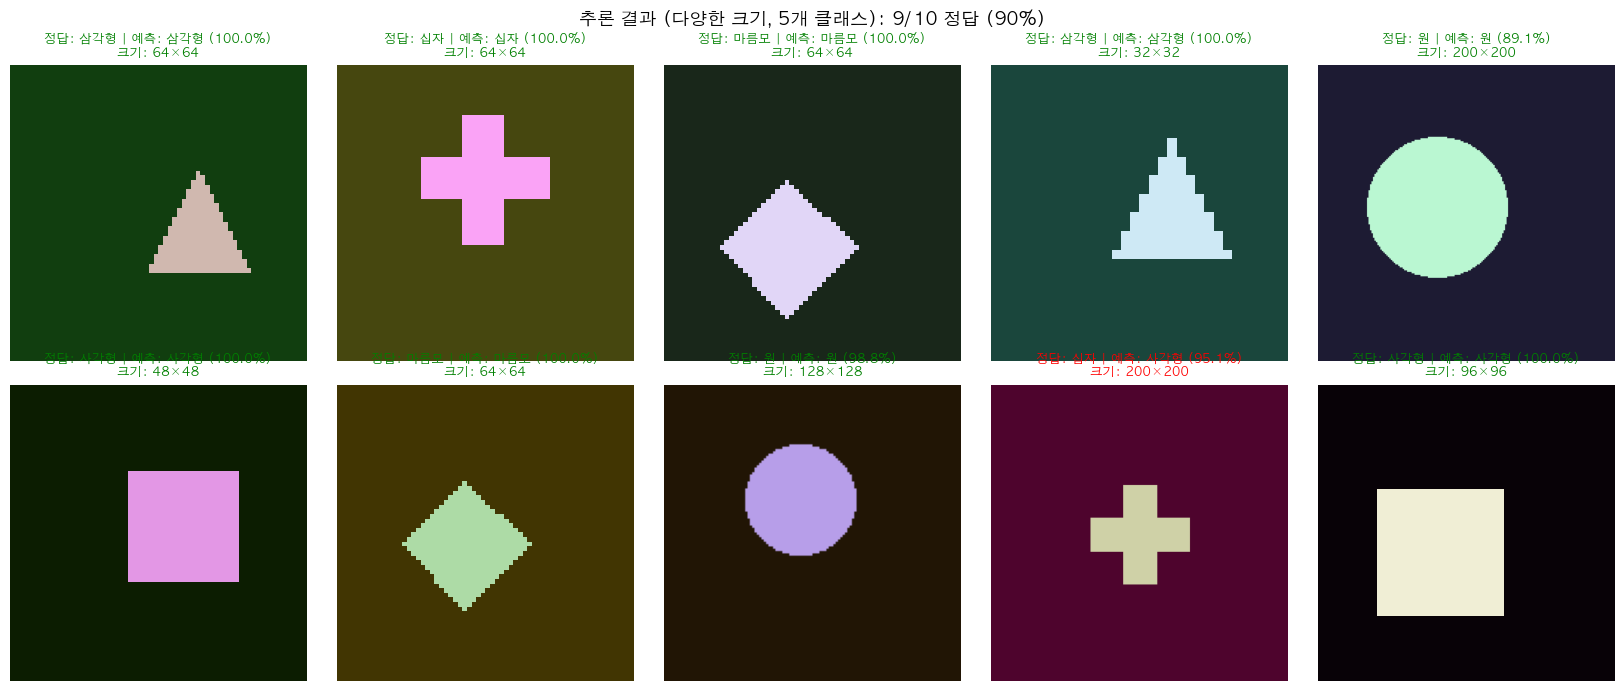


추론 정확도: 9/10 (90%)


In [11]:
# ── 새 이미지로 추론 테스트 (다양한 크기, 모든 클래스) ──
# 각 클래스 2장씩, 다양한 크기로 생성하여 예측합니다.
test_shapes = CLASS_NAMES * 2
random.shuffle(test_shapes)
n_test = len(test_shapes)
test_sizes = [random.choice([32, 48, 64, 96, 128, 200]) for _ in range(n_test)]

ncols = min(5, n_test)
nrows = (n_test + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(3.3 * ncols, 3.5 * nrows))
axes_flat = axes.flat if hasattr(axes, 'flat') else [axes]

correct = 0
for i, (ax, shape, img_sz) in enumerate(zip(axes_flat, test_shapes, test_sizes)):
    img = generate_shape_image(shape, img_size=img_sz)
    tensor = torch.from_numpy(np.array(img)).permute(2, 0, 1).float() / 255.0
    tensor = tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        logits = inference_model(tensor)
        probs = torch.softmax(logits, dim=1)
        pred_idx = probs.argmax(1).item()
        confidence = probs[0, pred_idx].item() * 100

    pred_name = CLASS_NAMES[pred_idx]
    is_correct = pred_name == shape
    correct += int(is_correct)

    color = "green" if is_correct else "red"
    ax.imshow(np.array(img))
    ax.set_title(
        f"정답: {CLASS_KR[shape]} | 예측: {CLASS_KR[pred_name]} ({confidence:.1f}%)\n"
        f"크기: {img_sz}×{img_sz}",
        color=color, fontsize=9
    )
    ax.axis("off")

# 남는 축 숨기기
for j in range(i + 1, nrows * ncols):
    axes_flat[j].axis("off")

accuracy = correct / n_test * 100
fig.suptitle(
    f"추론 결과 (다양한 크기, {NUM_CLASSES}개 클래스): {correct}/{n_test} 정답 ({accuracy:.0f}%)",
    fontsize=13, fontweight="bold"
)
plt.tight_layout()
plt.show()

print(f"\n추론 정확도: {correct}/{n_test} ({accuracy:.0f}%)")

## 6. 단일 이미지 추론 함수

In [12]:
def predict_single(model, img: Image.Image, device=device):
    """
    단일 PIL 이미지에 대해 예측 수행 (임의 크기 입력 가능)
    
    Args:
        model: 학습된 CNN 모델
        img: PIL.Image (임의 크기 가능 - AdaptiveAvgPool 덕분에 리사이즈 불필요)
        device: 연산 장치
    Returns:
        pred_kr: 예측된 클래스 (한글)
        result: 각 클래스별 확률 딕셔너리
    """
    model.eval()
    tensor = torch.from_numpy(np.array(img.convert("RGB"))).permute(2, 0, 1).float() / 255.0
    tensor = tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(tensor)
        probs = torch.softmax(logits, dim=1)[0]

    result = {
        CLASS_KR[cls]: f"{probs[i].item()*100:.1f}%"
        for i, cls in enumerate(CLASS_NAMES)
    }
    pred = CLASS_NAMES[probs.argmax().item()]
    return CLASS_KR[pred], result


# ── 테스트: 모든 클래스, 다양한 크기 ──
print("=" * 70)
sizes = [random.choice([48, 100, 128, 200]) for _ in CLASS_NAMES]
for shape, sz in zip(CLASS_NAMES, sizes):
    test_img = generate_shape_image(shape, img_size=sz)
    pred, probs = predict_single(inference_model, test_img)
    print(f"정답: {CLASS_KR[shape]:4s} ({sz:3d}×{sz:3d}) → 예측: {pred:4s} | 확률: {probs}")
print("=" * 70)

정답: 원    (100×100) → 예측: 원    | 확률: {'원': '100.0%', '사각형': '0.0%', '삼각형': '0.0%', '마름모': '0.0%', '십자': '0.0%'}
정답: 사각형  (100×100) → 예측: 사각형  | 확률: {'원': '0.0%', '사각형': '100.0%', '삼각형': '0.0%', '마름모': '0.0%', '십자': '0.0%'}
정답: 삼각형  (128×128) → 예측: 삼각형  | 확률: {'원': '3.3%', '사각형': '0.0%', '삼각형': '96.7%', '마름모': '0.0%', '십자': '0.0%'}
정답: 마름모  (128×128) → 예측: 마름모  | 확률: {'원': '0.2%', '사각형': '0.0%', '삼각형': '0.0%', '마름모': '99.7%', '십자': '0.0%'}
정답: 십자   (100×100) → 예측: 십자   | 확률: {'원': '0.0%', '사각형': '0.0%', '삼각형': '0.0%', '마름모': '0.0%', '십자': '100.0%'}


---
## 요약

### 전체 파이프라인 완료

| 단계 | 내용 | 결과 |
|------|------|------|
| 데이터 생성 | PIL로 가상 도형 이미지 생성 | train + val 자동 생성 |
| 데이터 로딩 | PyTorch Dataset/DataLoader | 배치 크기 32 |
| 모델 | 3-layer CNN + AdaptiveAvgPool | 입력 크기 자유, 클래스 수 자동 |
| 학습 | 15 에폭, Adam, lr=0.001 | Val Accuracy 확인 |
| 추론 | 다양한 크기의 새 이미지 테스트 | 리사이즈 없이 바로 추론 |

### 핵심 설계
- **`CLASS_NAMES` 수정만으로** 클래스 수 자유롭게 확장 가능
- **`AdaptiveAvgPool2d`** 덕분에 어떤 크기의 이미지든 추론 가능
- **`generate_shape_image`에 elif 블록 추가**로 새 도형 지원